# Анализ и план действий по удержанию клиентов фитнес-центра

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных. Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.

Задача — провести анализ электронных анкет пользователей и подготовить план действий по удержанию клиентов.

Оглавление

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Импорт библиотек для ML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import itertools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

## <a id="loading">1. Загрузка и подготовка исходных данных</a>

In [4]:
# Прочитаем csv файл
gym = pd.read_csv('gym_churn.csv')
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
# Посмотрим размер таблицы
gym.shape

(4000, 14)

Таблица содержит 4000 записей и 14 столбцов.

### Названия столбцов в датасете

- 'Churn' — факт оттока в текущем месяце

Текущие поля в датасете:

Данные пользователя за предыдущий до проверки факта оттока месяц:
- 'gender' — пол
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр+
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- 'Phone' — наличие контактного телефона
- 'Age' — возраст
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
- 'Group_visits' — факт посещения групповых занятий
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

In [6]:
# Посмотрим детальную информацию о таблице
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [7]:
# Проверим на дубликаты
gym.duplicated().mean()

0.0

На первый взгляд, все нормально: пропусков и дубликатов нет, форматы данных корректны. Можно работать.

## 2. Исследовательский анализ данных (EDA)

### 2.1. Отсутствующие признаки, средние значения и стандартные отклонения

In [8]:
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [9]:
# Создадим таблицу только с признаками, которые имеют небинарное значение
num_gym = gym.drop(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits', 'Churn'], axis = 1)
num_gym.head()

,Contract_period,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,6,29,14.227470,5.0,3,0.020398,0.000000
1,12,31,113.202938,12.0,7,1.922936,1.910244
2,1,28,129.448479,1.0,2,1.859098,1.736502
3,12,33,62.669863,12.0,2,3.205633,3.357215
4,1,26,198.362265,1.0,3,1.113884,1.120078


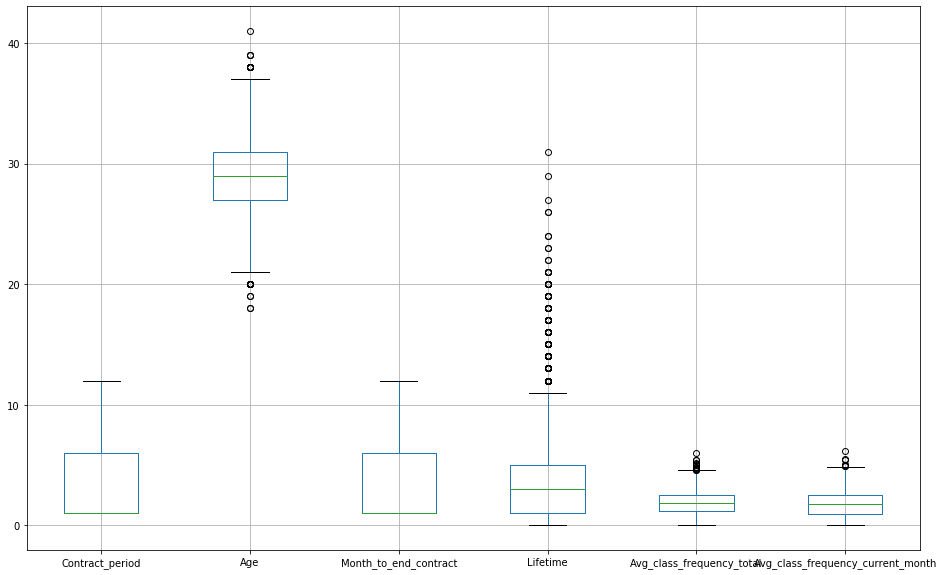

In [10]:
#Построим боксплоты по признакам
num_gym.drop('Avg_additional_charges_total', axis = 1).boxplot(figsize = (16, 10))
plt.show()

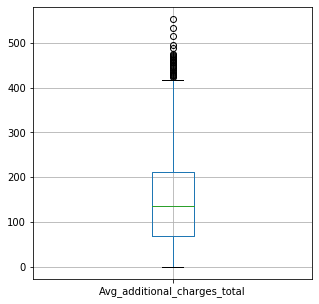

In [11]:
num_gym.boxplot(column = 'Avg_additional_charges_total', figsize = (5, 5))
plt.show()

По боксплотам видно, что в значениях признаков есть выбросы. При построении модели их можно будет почистить для повышения точности.

In [12]:
# Посчитаем средние значения признаков
avg_values = pd.DataFrame(columns = ['feature', 'mean'])

for column in num_gym:
    mean = num_gym[column].mean()
    avg_values = avg_values.append({'feature':column, 'mean':mean}, ignore_index=True)
    

avg_values

,feature,mean
0,Contract_period,4.681250
1,Age,29.184250
2,Avg_additional_charges_total,146.943728
3,Month_to_end_contract,4.322750
4,Lifetime,3.724750
5,Avg_class_frequency_total,1.879020
6,Avg_class_frequency_current_month,1.767052


In [13]:
# Сделал и подумал что то же самое можно было сделать проще, но пусть остается и первый вариант
num_gym.mean().to_frame().reset_index().colimns = ['feature', 'mean']

In [14]:
num_gym['Contract_period'].describe()

count    4000.000000
mean        4.681250
std         4.549706
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: Contract_period, dtype: float64

In [15]:
# Посчитаем стандарные отклонения признаков
num_gym_std = num_gym.std().to_frame().reset_index()
num_gym_std.columns = ['feature', 'std']

In [16]:
# Соберем в одну таблицу средние значения и стандартные отклонения признаков
avg_values.merge(num_gym_std, how = 'left', left_on= 'feature', right_on= 'feature')

,feature,mean,std
0,Contract_period,4.681250,4.549706
1,Age,29.184250,3.258367
2,Avg_additional_charges_total,146.943728,96.355602
3,Month_to_end_contract,4.322750,4.191297
4,Lifetime,3.724750,3.749267
5,Avg_class_frequency_total,1.879020,0.972245
6,Avg_class_frequency_current_month,1.767052,1.052906


### 2.2. Средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [17]:
# Посчитаем средние значения по группам, кто остался (1) и кто ушел (0) 
churn_grouped_mean = gym.groupby('Churn')[['Contract_period', 'Age', 'Avg_additional_charges_total',
                     'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 
                      'Avg_class_frequency_current_month']].mean()
churn_grouped_mean

,Contract_period,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,
0,5.747193,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1.728558,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Все средние значения признаков меньше у тех кто ушел в отток.

In [18]:
gym['Churn'].value_counts()

0    2939
1    1061
Name: Churn, dtype: int64

В нашем датасете: остались - 2939, ушло в отток - 1061.

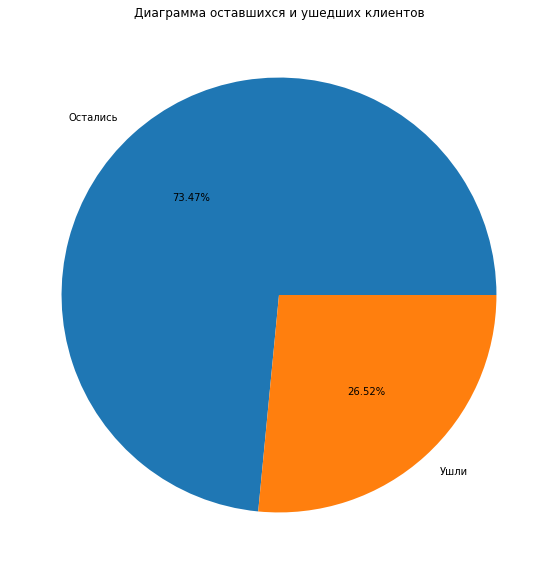

In [19]:
# Построим диаграмму оставшихся и ушедших клиентов
plt.figure(figsize = (16,10))
values = gym['Churn'].value_counts()
labels = ['Остались', 'Ушли'] 
plt.pie(values, labels=labels, autopct='%.2f%%')
plt.title('Диаграмма оставшихся и ушедших клиентов')
plt.show()

В процентах это: 73,5% - осталось; 26,5% - ушло.

In [20]:
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Портрет среднестатисического "хорошего" клиента, который остается
- Возраст - около 30 лет
- суммарная выручка от других услуг фитнес-центра 158 рублей/тыс рублей?
- время до окончания абонемента - 5 месяцев (длинный абонемент)
- время с момента первого обращения в фитнес-центр более 5 месяцев
- постоянно ходит на занятия 2 раза в неделю

Портрет среднестатисического клиента, который уходит в отток
- Возраст - меньше 30 лет
- суммарная выручка от других услуг фитнес-центра низкая - 115 рублей/тыс рублей?
- время до окончания абонемента - 1,5 - 2 месяца (короткий абонемент)
- время с момента первого обращения в фитнес-центр 1 месяц
- ходит на занятия 1 раз в неделю, сначала ходил чаще

### 2.3. Столбчатые гистограммы и распределения признаков для тех кто ушёл и тех кто остался

In [21]:
# Выделим в таблицу бинарные признаки
binary_gym = gym[['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits', 'Churn']]

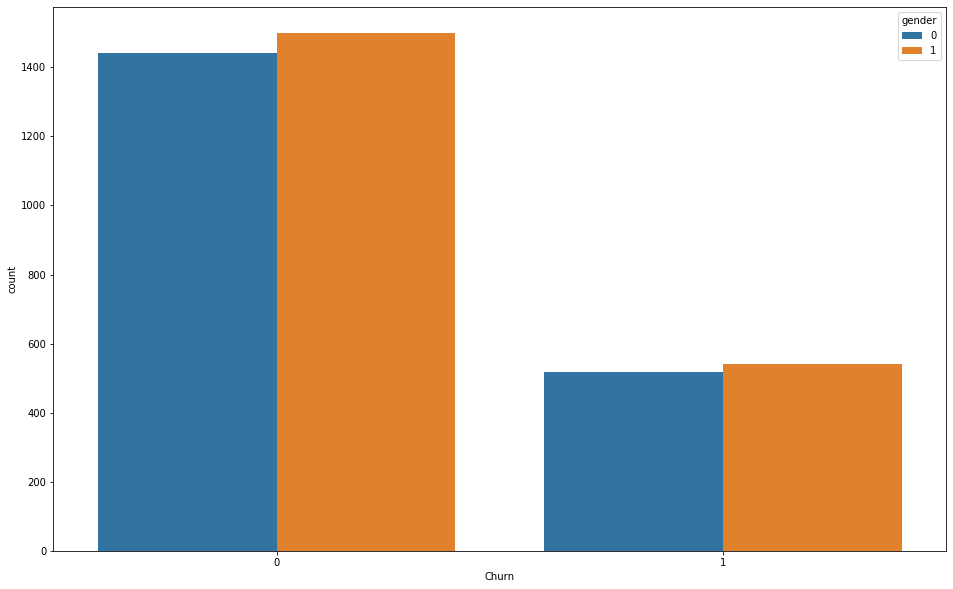

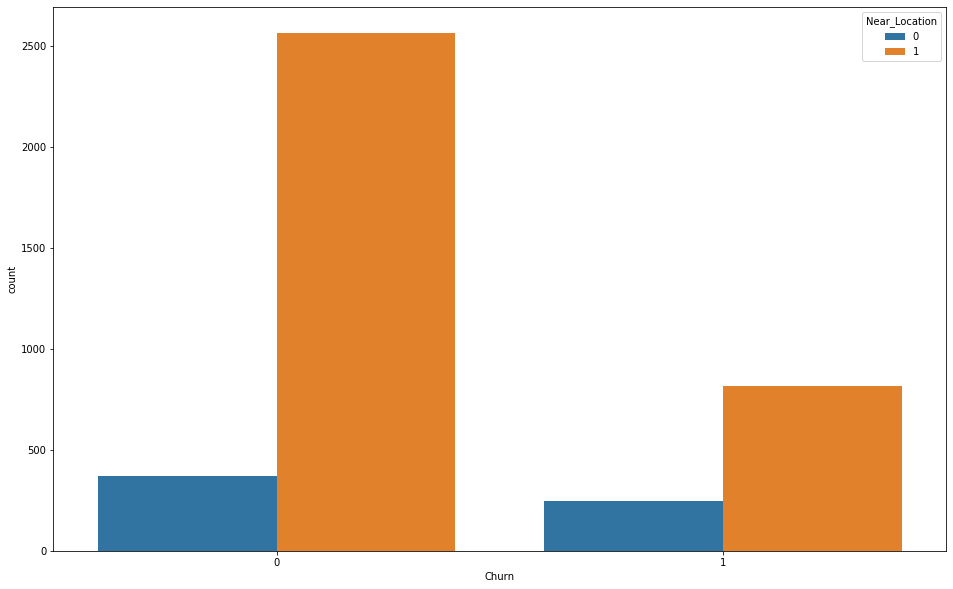

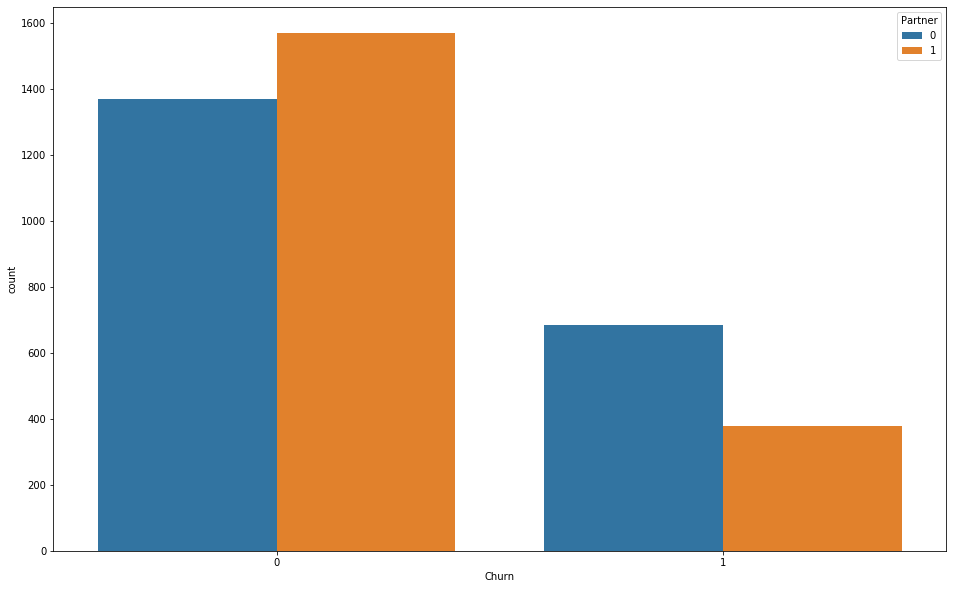

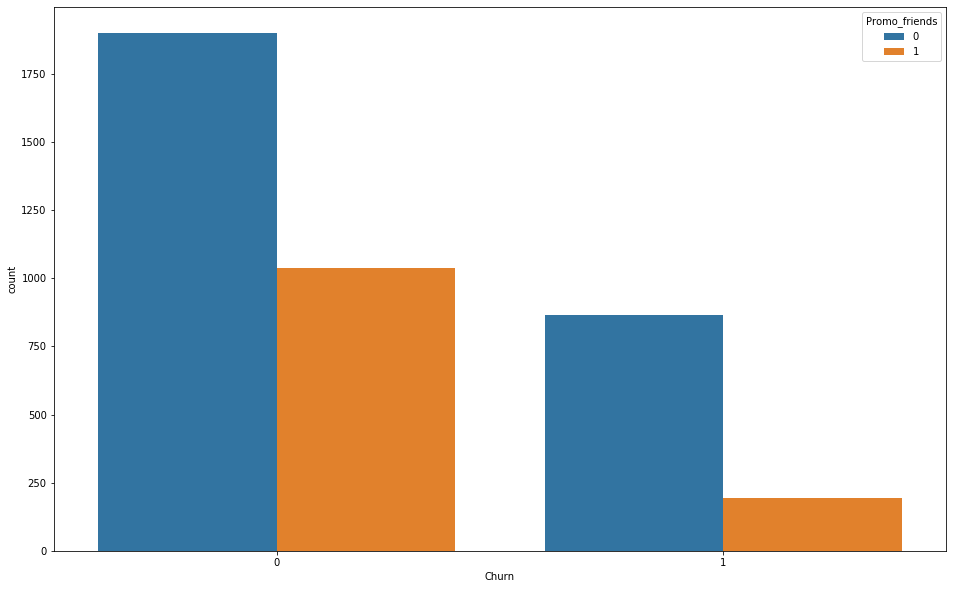

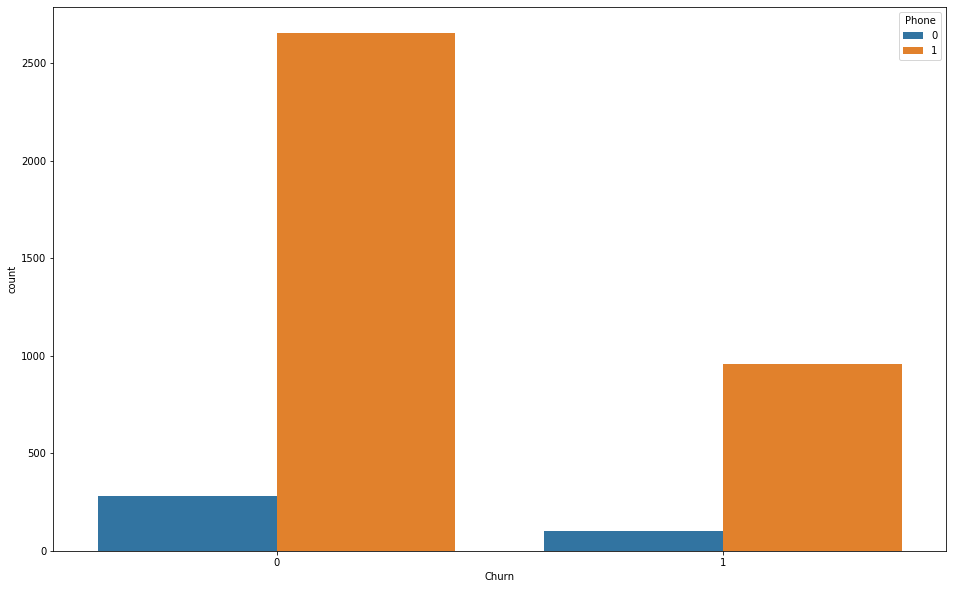

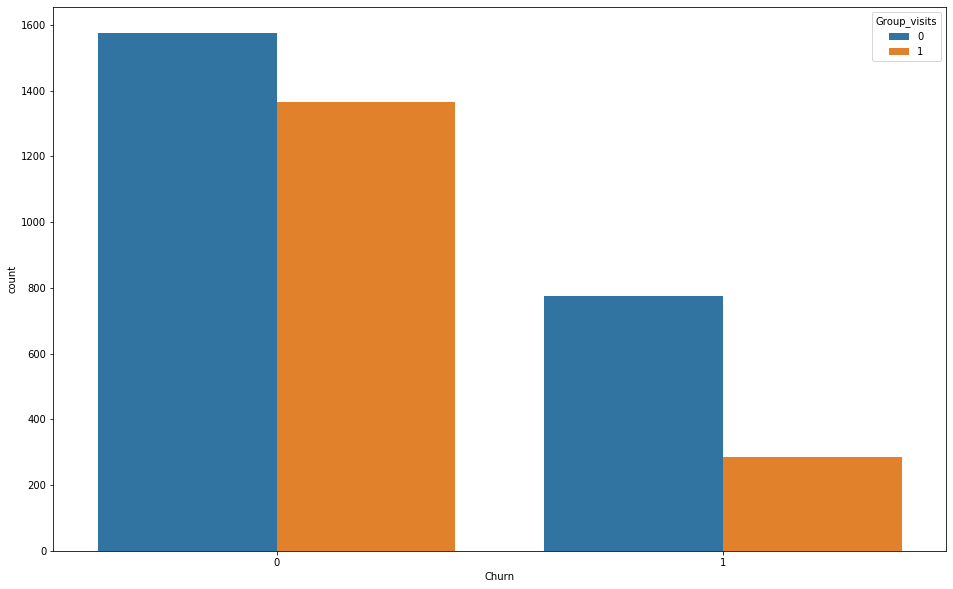

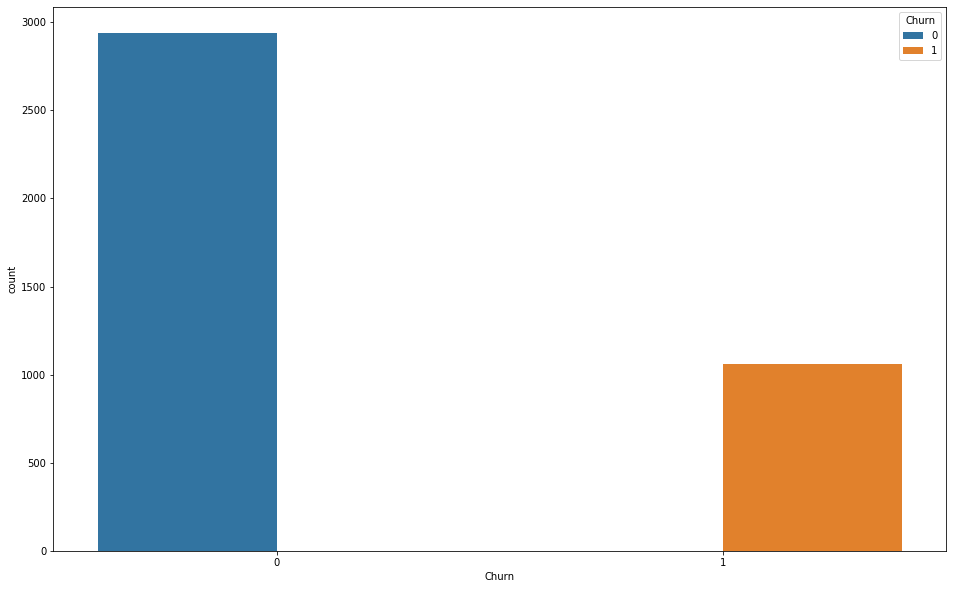

In [22]:
for column in binary_gym:
    plt.figure(figsize=(16, 10))
    sns.countplot(gym['Churn'], hue = gym[column])
    plt.show()

Выводы по распределению бинарных признаков среди тех кто ушел и остался:
- пол различия не имеет
- среди тех кто остался гораздо больше тех, кто живет/работает рядом
- среди тех кто остался больше сотрудников партнерской программы
- среди тех кто остался больше тех кто пришел по акции "приведи друга"
- наличие телефона не влияет на отток (среди тех кто ушел, почти все были с номером телефона)
- cреди тех кто остался, клиенты чаще посещали групповые занятия

In [23]:
# Сформируем объект groupby с группировкой по оттоку
grouped = gym.groupby('Churn')

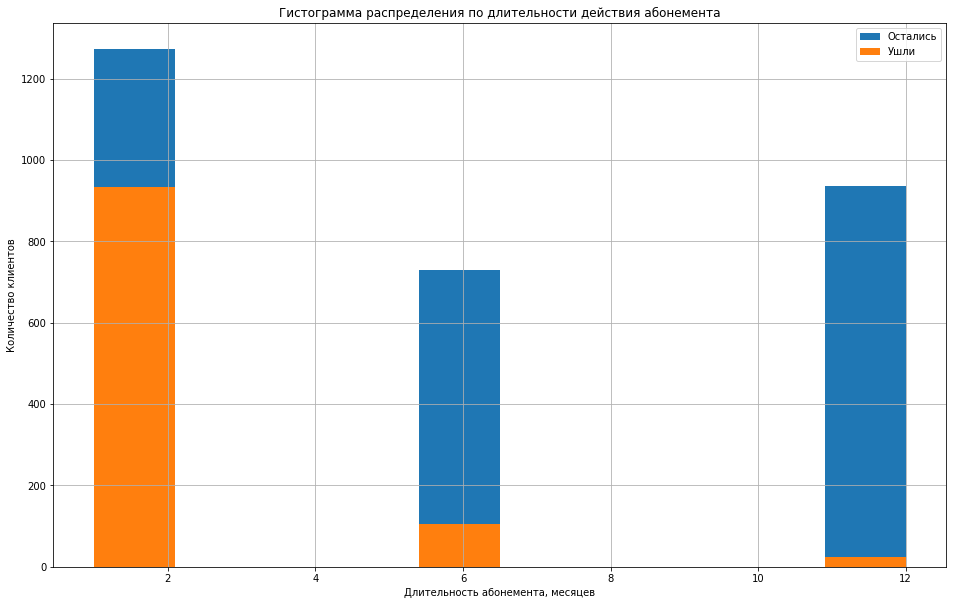

In [24]:
# Построим гистограммы по небинарным признакам
plt.figure(figsize=(16, 10))
grouped['Contract_period'].hist()
plt.title('Гистограмма распределения по длительности действия абонемента')
plt.xlabel('Длительность абонемента, месяцев')
plt.ylabel('Количество клиентов')
plt.legend(labels)
plt.show()

Из графика видно, что больше всего ушедших с коротким сроком абонемента, и наоборот из клиентов с годовым абонементом отток небольшой.

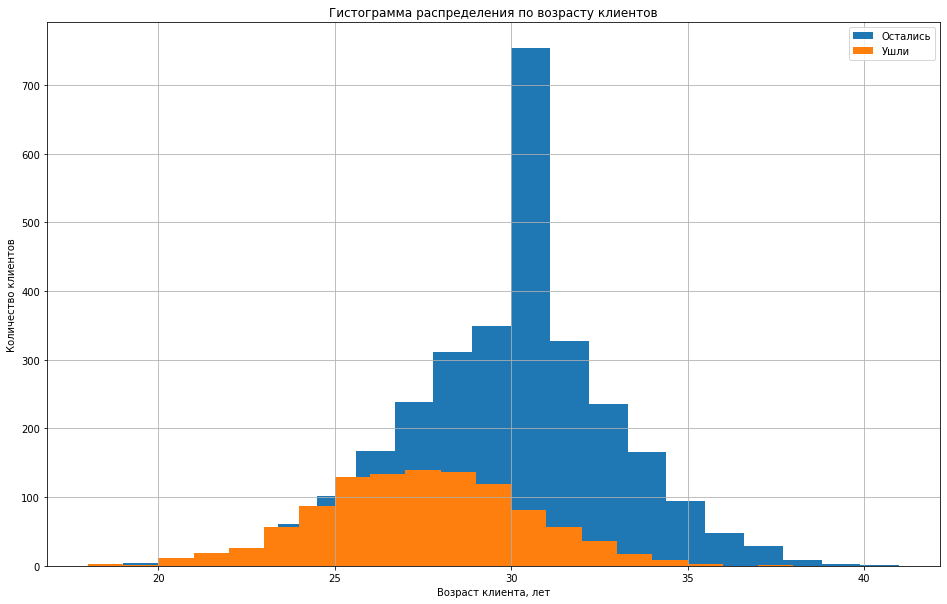

In [25]:
plt.figure(figsize=(16, 10))
grouped['Age'].hist(bins = 20)
plt.title('Гистограмма распределения по возрасту клиентов')
plt.xlabel('Возраст клиента, лет')
plt.ylabel('Количество клиентов')
plt.legend(labels)
plt.show()

Из графика видно, что распределение по возрасту среди ушедших смещено в сторону более молодых.

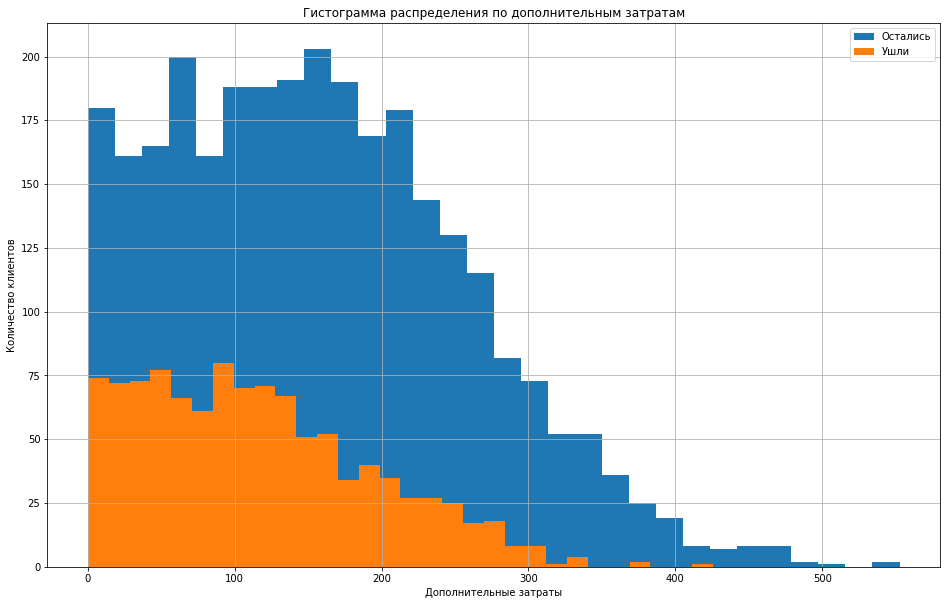

In [26]:
plt.figure(figsize=(16, 10))
grouped['Avg_additional_charges_total'].hist(bins = 30)
plt.title('Гистограмма распределения по дополнительным затратам')
plt.xlabel('Дополнительные затраты')
plt.ylabel('Количество клиентов')
plt.legend(labels)
plt.show()

Распределение ушедших смещено сторону более низких сумм, среди оставшихся клиентов больше тех, кто тратит больше на дополнительные услуги.

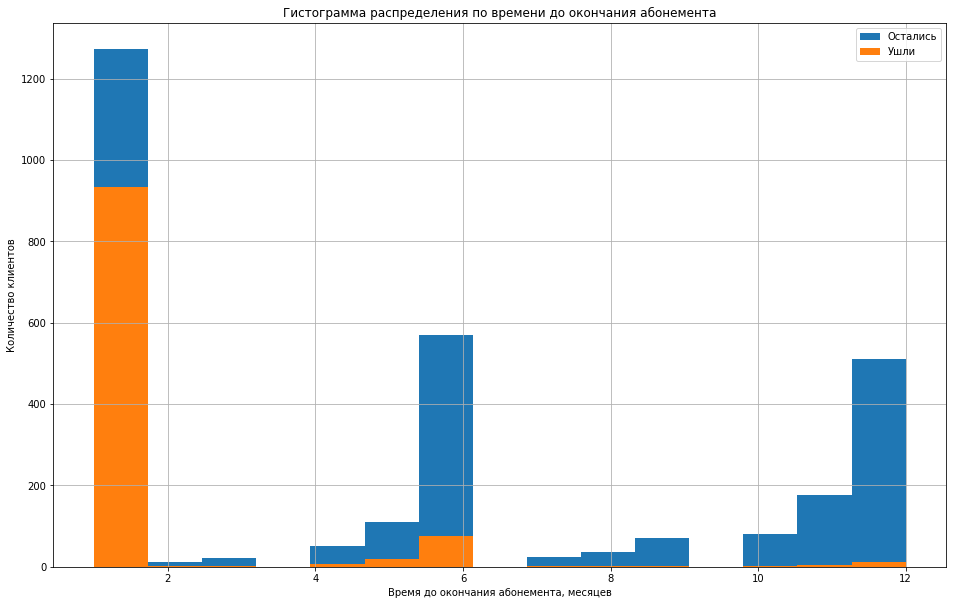

In [27]:
plt.figure(figsize=(16, 10))
grouped['Month_to_end_contract'].hist(bins = 15)
plt.title('Гистограмма распределения по времени до окончания абонемента')
plt.xlabel('Время до окончания абонемента, месяцев')
plt.ylabel('Количество клиентов')
plt.legend(labels)
plt.show()

Опять же, уходят больше те у кого заканчивается срок абонемента.

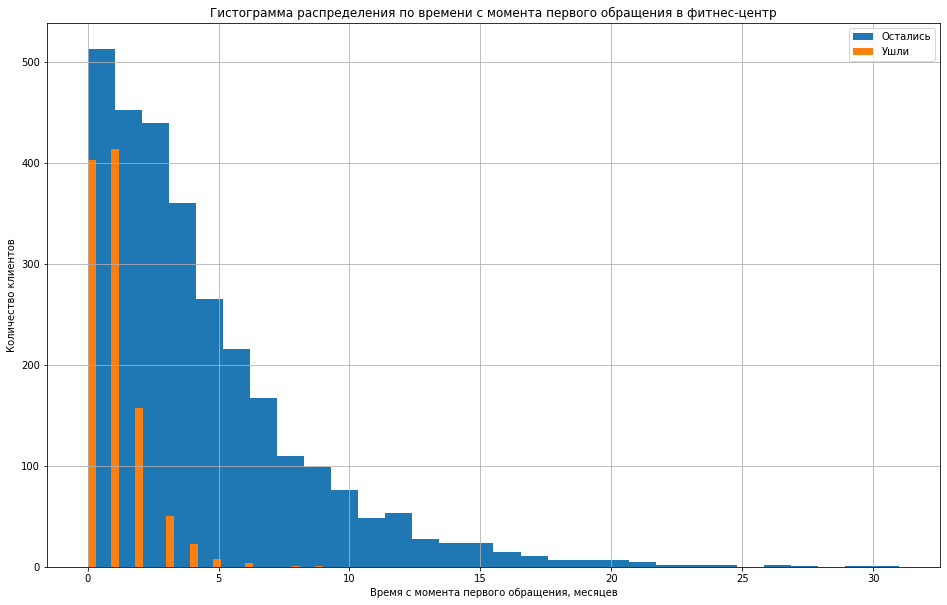

In [28]:
plt.figure(figsize=(16, 10))
grouped['Lifetime'].hist(bins = 30)
plt.title('Гистограмма распределения по времени с момента первого обращения в фитнес-центр')
plt.xlabel('Время с момента первого обращения, месяцев')
plt.ylabel('Количество клиентов')
plt.legend(labels)
plt.show()

Среди ушедших в основном "молодые клиенты".

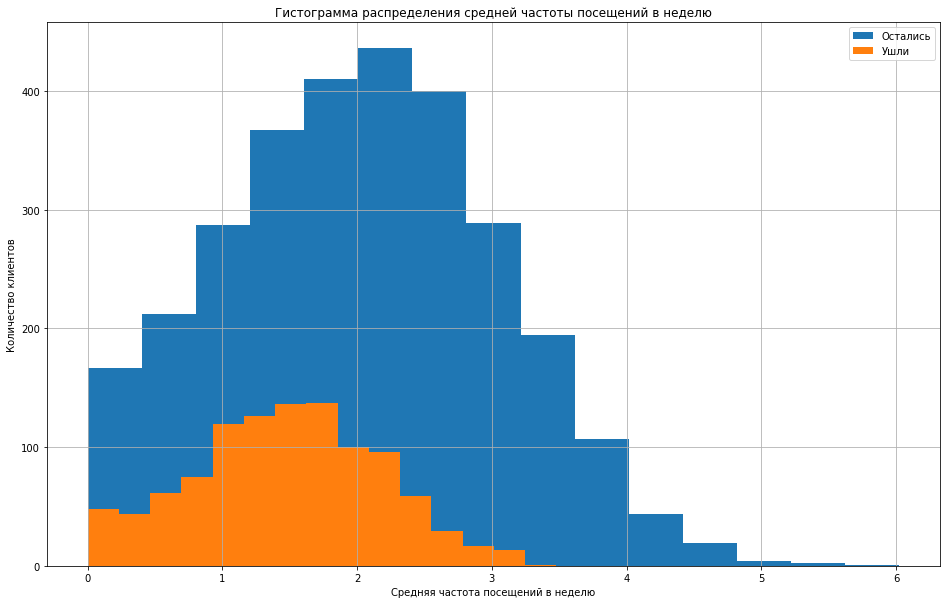

In [29]:
plt.figure(figsize=(16, 10))
grouped['Avg_class_frequency_total'].hist(bins = 15)
plt.title('Гистограмма распределения средней частоты посещений в неделю')
plt.xlabel('Средняя частота посещений в неделю')
plt.ylabel('Количество клиентов')
plt.legend(labels)
plt.show()

Те кто остались, посещают занятия немного чаще.

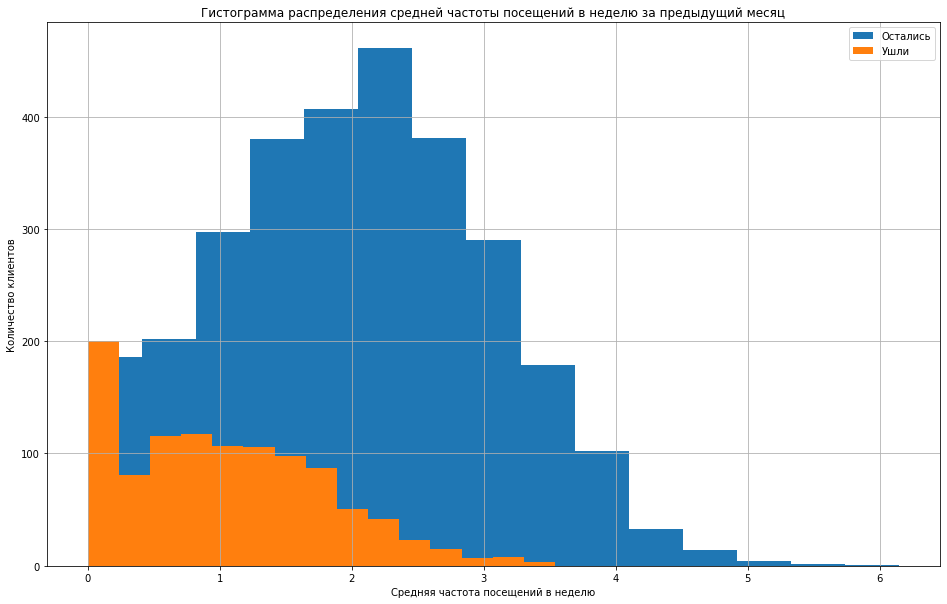

In [30]:
plt.figure(figsize=(16, 10))
grouped['Avg_class_frequency_current_month'].hist(bins = 15)
plt.title('Гистограмма распределения средней частоты посещений в неделю за предыдущий месяц')
plt.xlabel('Средняя частота посещений в неделю')
plt.ylabel('Количество клиентов')
plt.legend(labels)
plt.show()

Здесь уже картина более явная - те кто остались ходили на занятия более регулярно. Те клиенты, что ушли - их посещаемость заметно снизилась.

### 2.4. Матрица корреляций

In [31]:
# Построим матрицу корреляций признаков
gym.corr()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
Near_Location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
Partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
Promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
Phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
Contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
Group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
Age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
Avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
Month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


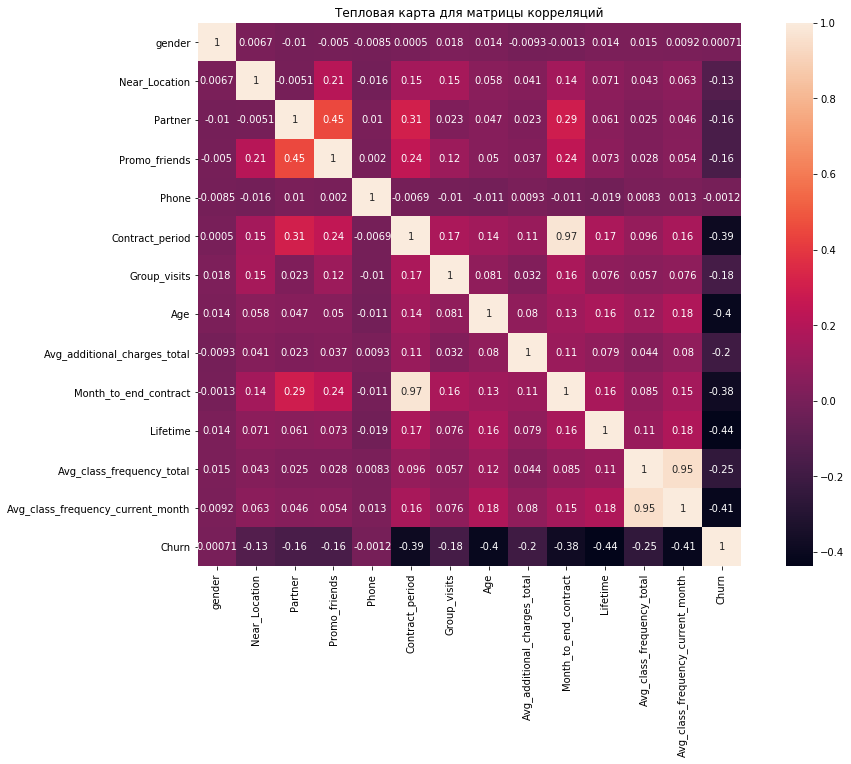

In [32]:
# Построим тепловую карту корреляции
plt.figure(figsize = (16,10))
sns.heatmap(gym.corr(), annot = True, square = True)
#ax.set_ylim(7, 0)
plt.title('Тепловая карта для матрицы корреляций')
plt.show()

Матрица корреляций, в целом подтверждает те выводы, что были сделаны по гистограммам распределения.

Если рассматривать переменную Churn, то все признаки имеют с ней отрицательную корреляцию, т.е. при увеличении их величин, величина Churn уменьшается (хоть она и бинарная). Таким образом, наибольшее влияние на Churn по матрице корреляций мы видим:
- Длительность абонемента (Contract period) (-0.39)
- Возраст (Age) (-0.4)
- Время до окончания абонемента (Month_to_end_contract) (-0.38)
- Время с первого обращения в фитнес-центр (Lifetime) (-0.44)
- Частота посещения в текущем месяце (Avg_class_frequency_current_month) (-0.41)

Что еще интересного по матрице корреляций можно отметить:

Сильную зависимость (0.97) переменных: 
- Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента и 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц. 
- 'Contract_period' — длительность текущего действующего абонемента и 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
Это абсолютно логично.

Также можно выделить положительную корреляцию (0.45) переменных 'Partner' — сотрудник компании-партнёра клуба и Promo_friends — факт первоначальной записи в рамках акции «приведи друга» - что тоже выглядит логичным - сотрудники компаний общаются между собой.

И положительную корреляцию переменных (0.31) 'Partner' — сотрудник компании-партнёра клуба и 'Contract_period' — длительность текущего действующего абонемента, что тоже выглядит логичным - длинные абонементы обычно продают со скидкой корпоративным клиентам.

## Выводы по исследовательскому анализу:
В нашем датасете: остались - 2939 (73,5%), ушло в отток - 1061(26,5%).

- В значениях признаков есть выбросы, они могут повлиять на результаты при построении модели.
- Все средние значения признаков меньше у тех кто ушел в отток.

Выводы по признакам среди тех кто ушел и остался:

- пол не влияет на отток
- среди тех кто остался гораздо больше тех, кто живет/работает рядом
- среди тех кто остался больше сотрудников партнерской программы
- среди тех кто остался больше тех кто пришел по акции "приведи друга"
- наличие в базе контактов номера телефона не влияет на отток
- больше всего ушедших с коротким сроком абонемента, и наоборот из клиентов с годовым абонементом отток небольшой
- распределение по возрасту среди ушедших смещено в сторону более молодых
- среди оставшихся клиентов больше тех, кто тратит больше на дополнительные услуги
- уходят чаще те, у кого заканчивается срок абонемента.
- среди ушедших в основном "молодые клиенты" - у кого меньше история взаимодействия с фитнес-центром
- те кто остались, посещали занятия чаще тех кто ушел, особенно это заметно в последнем месяце

## 3. Построение модели прогнозирования оттока пользователей

In [33]:
# Разделим наши данные на признаки (матрица X) и целевую переменную (y), одновременно удалим ненужные (маловлияющие) признаки
X = gym.drop(['Churn', 'gender', 'Phone'], axis = 1)
y = gym['Churn']

In [34]:
# Разделим модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [35]:
# Создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()

# Обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_train_st = scaler.fit_transform(X_train) 

In [36]:
# Применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

In [37]:
# Задаем алгоритм для модели
model = LogisticRegression(random_state = 0)

In [38]:
# Обучаем модель
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
# Сделаем бинарный прогноз
predictions = model.predict(X_test)

In [40]:
# Выведем метрики для полученного прогноза
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score (y_test, predictions)))

Accuracy: 0.90
Precision: 0.81
Recall: 0.79


У нас получились довольно высокие показатели метрик для использованной модели.


In [41]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [42]:
rf_predictions = rf_model.predict(X_test_st)

In [43]:
# Выведем метрики для полученного прогноза
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score (y_test, rf_predictions)))

Accuracy: 0.92
Precision: 0.86
Recall: 0.83


Модель с алгоритмом случайного леса дает более высокие показатели метрик, следовательно она для данного случая предпочтительней.

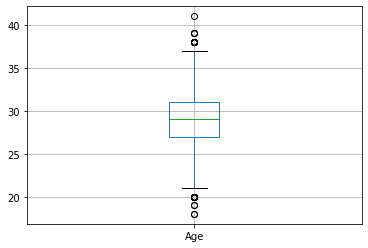

In [44]:
gym.boxplot(['Age'])

In [45]:
gym['Age'].describe()

count    4000.000000
mean       29.184250
std         3.258367
min        18.000000
25%        27.000000
50%        29.000000
75%        31.000000
max        41.000000
Name: Age, dtype: float64

In [46]:
good_gym = gym[(gym['Age'] >=21) & (gym['Age'] <=36)]

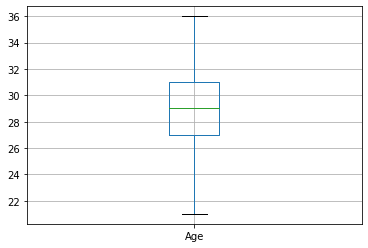

In [47]:
good_gym.boxplot(['Age'])

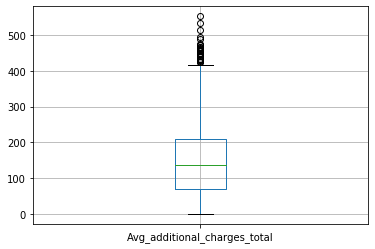

In [48]:
good_gym.boxplot(['Avg_additional_charges_total'])

In [49]:
good_gym = good_gym[good_gym['Avg_additional_charges_total'] <410]

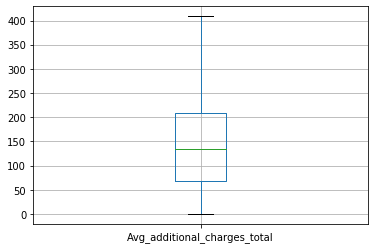

In [50]:
good_gym.boxplot(['Avg_additional_charges_total'])

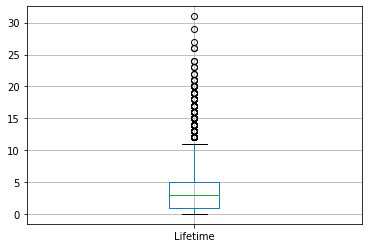

In [51]:
good_gym.boxplot(['Lifetime'])

In [52]:
good_gym = good_gym[good_gym['Lifetime'] <11]

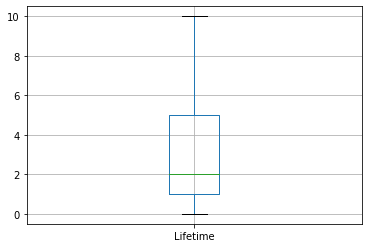

In [53]:
good_gym.boxplot(['Lifetime'])

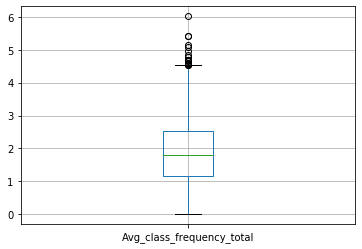

In [54]:
good_gym.boxplot(['Avg_class_frequency_total'])

In [55]:
good_gym = good_gym[good_gym['Avg_class_frequency_total'] <4.3]

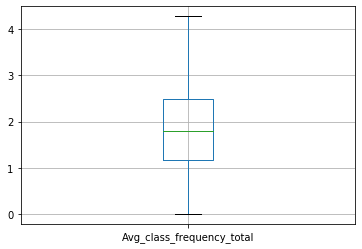

In [56]:
good_gym.boxplot(['Avg_class_frequency_total'])

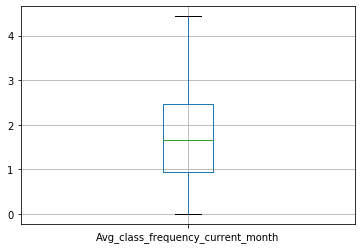

In [57]:
good_gym.boxplot(['Avg_class_frequency_current_month'])

In [58]:
len(good_gym) / len(gym)

0.91075

Мы очистили выбросы и убрали 9% записей.

Проверим теперь модели на чистых данных.

In [59]:
# Разделим наши данные на признаки (матрица X) и целевую переменную (y), одновременно удалим ненужные (маловлияющие) признаки
X = good_gym.drop(['Churn', 'gender', 'Phone'], axis = 1)
y = good_gym['Churn']

# Разделим модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()

# Обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_train_st = scaler.fit_transform(X_train) 

# Применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

# Задаем алгоритм для модели
model = LogisticRegression(random_state = 0)

# Обучаем модель
model.fit(X_train, y_train)

# Сделаем бинарный прогноз
predictions = model.predict(X_test)

# Выведем метрики для полученного прогноза
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score (y_test, predictions)))

Accuracy: 0.92
Precision: 0.87
Recall: 0.82


Метрики на модели, обученной на очищенных от выбросов данных получились выше.

Проверим на алгоритме случайный лес

In [60]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

rf_predictions = rf_model.predict(X_test_st)

# Выведем метрики для полученного прогноза
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score (y_test, rf_predictions)))

Accuracy: 0.93
Precision: 0.90
Recall: 0.84


В данном случае выросла только метрика Precision на 3%.

Подтвердилась гипотеза, что модели, обученная на очищенных от выбросов данных дают более точные предсказания. Алгоритм модели случайный лес дает более точный прогноз чем алгоритм логистической регрессии.

### Выводы по моделям прогнозирования оттока

Метрики моделей на сырых данных:

Логистическая регрессия
- Accuracy: 0.90
- Precision: 0.81
- Recall: 0.79

Случайный лес
- Accuracy: 0.92
- Precision: 0.86
- Recall: 0.83

Метрики моделей на очищенных от выбросов данных:

Логистическая регрессия
- Accuracy: 0.92
- Precision: 0.87
- Recall: 0.82

Случайный лес
- Accuracy: 0.92
- Precision: 0.89
- Recall: 0.83

Мы очистили выбросы и убрали 9% записей.
После очистки данных от выбросов, обученные на них модели дают более точные прогнозы.
Для данного случая предпочительно использование алгоритма случайный лес, у него выше точность.

## 4. Кластеризация пользователей

In [61]:
# Стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(gym.drop('Churn', axis = 1))

In [62]:
# Построим матрицу расстояний
Z = linkage(x_sc, 'ward')

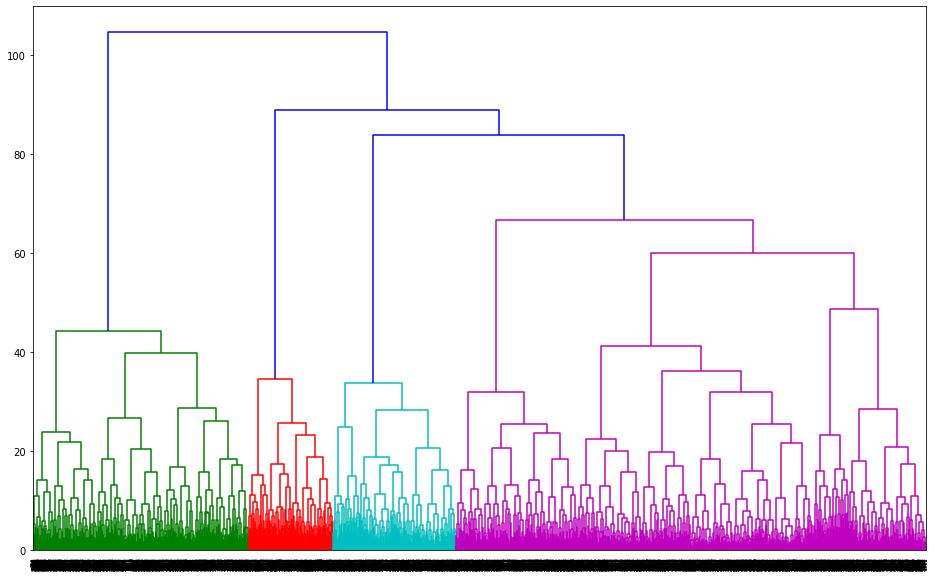

In [63]:
# Построим дендрограмму
fig = plt.figure(figsize=(16, 10))
dn = dendrogram(Z)
plt.show()

На основании полученного графика предположите, можно выделить 4 кластера.

In [64]:
# Зададим модель k_means с количеством кластеров 5
km = KMeans(n_clusters = 5)
# Спрогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)

# Сохраним метки кластера в поле нашего датасета
gym['5_cluster_km'] = labels

# Сгруппируем признаки по 5 кластерам и посчитаем средние
gym.groupby('5_cluster_km').agg({'Contract_period':'mean', 'Age':'mean', 'Avg_additional_charges_total':'mean',
                              'Month_to_end_contract':'mean', 'Lifetime':'mean', 'Avg_class_frequency_total':'mean', 
                              'Avg_class_frequency_current_month':'mean'})

,Contract_period,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
5_cluster_km,,,,,,,
0,1.955894,28.153168,131.641154,1.862871,2.401764,1.240021,1.003166
1,2.661610,30.112019,161.078201,2.455076,4.901984,2.835280,2.832548
2,2.359684,28.480237,135.685249,2.205534,2.806324,1.663497,1.481161
3,10.913433,29.982090,160.690485,9.975124,4.748259,1.977143,1.969647
4,4.787013,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369


In [65]:
# Зададим модель k_means с количеством кластеров 4
#km = KMeans(n_clusters = 4)
# Спрогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
#labels = km.fit_predict(x_sc)

In [66]:
# Сохраним метки кластера в поле нашего датасета
#gym['cluster_km'] = labels

In [67]:
# Сгруппируем признаки по кластерам и посчитаем средние
#gym.groupby('cluster_km').agg({'Contract_period':'mean', 'Age':'mean', 'Avg_additional_charges_total':'mean',
#                              'Month_to_end_contract':'mean', 'Lifetime':'mean', 'Avg_class_frequency_total':'mean', 
#                              'Avg_class_frequency_current_month':'mean'})

По средним признакам кластеров можно сформулировать несколько групп клиентов:
 - "старички" - те кто давно ходит в зал, длительный абонемент, ходят 2 раза в неделю, тратят много на дополнительные услуги
 - "молодежь" - недавно пришли, короткий абонемент, ходят в среднем 1 раз в неделю, мало тратят на дополнительные услуги
 - "середнячки" - все показатели средние
 - "качки" - длительность абонемента средняя, много тратит на дополнительные услуги, давно ходят в зал, ходят на занятия 3 раза в неделю
 - "супер-старички" - те кто усердно занимаются, ходят 3 раза в неделю, но у них короткий абонемент, много тратят, давно ходят в зал

In [68]:
# Cоздадим объект groupby с группировкой по кластерам
cluster_gym = gym.groupby('5_cluster_km')

In [69]:
# Зададим метки кластеров для графика
cluster_labels = ['0', '1', '2', '3', '4']

In [70]:
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,5_cluster_km
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,4
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,3
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,3
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,0


In [71]:
cluster_0 = gym[gym['5_cluster_km'] == 0]
cluster_1 = gym[gym['5_cluster_km'] == 1]
cluster_2 = gym[gym['5_cluster_km'] == 2]
cluster_3 = gym[gym['5_cluster_km'] == 3]
cluster_4 = gym[gym['5_cluster_km'] == 4]

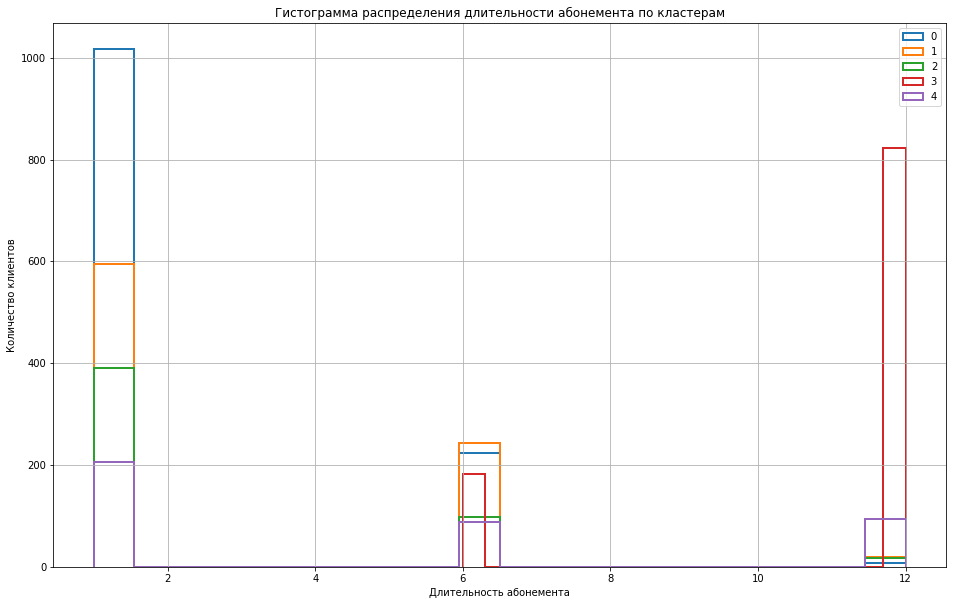

In [72]:
# Построим гистограммы признаков по кластерам
plt.figure(figsize=(16, 10))
cluster_gym['Contract_period'].hist(bins = 20, histtype = 'step', linewidth = 2)
plt.title('Гистограмма распределения длительности абонемента по кластерам')
plt.xlabel('Длительность абонемента')
plt.ylabel('Количество клиентов')
plt.legend(cluster_labels)
plt.show()

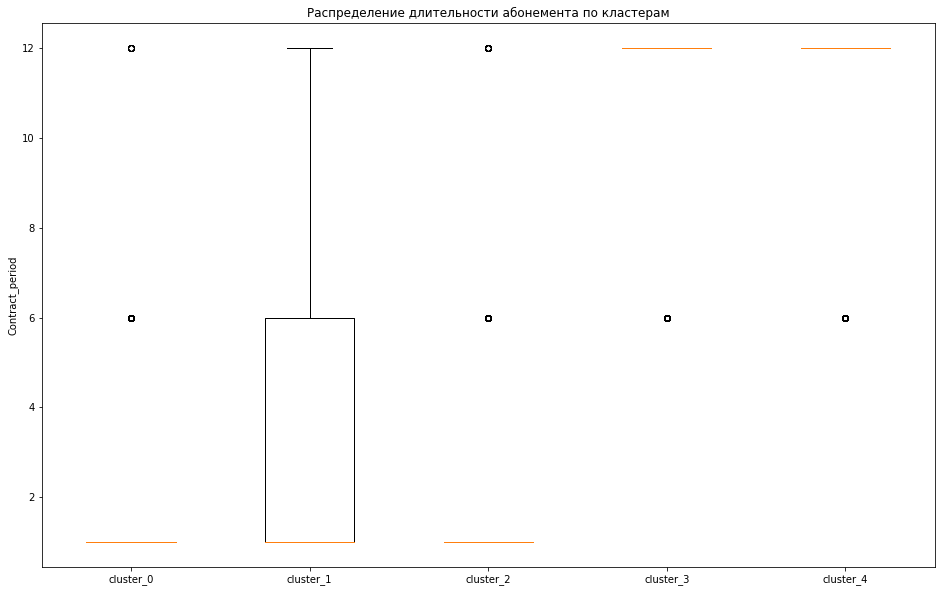

In [73]:
data_to_plot = [cluster_0['Contract_period'],
                cluster_1['Contract_period'],
               cluster_2['Contract_period'],
               cluster_3['Contract_period'],
               cluster_3['Contract_period']]

fig = plt.figure(figsize=(16, 10))

plt.boxplot(data_to_plot, labels = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])
plt.ylabel('Contract_period')
plt.title('Распределение длительности абонемента по кластерам')
plt.show()

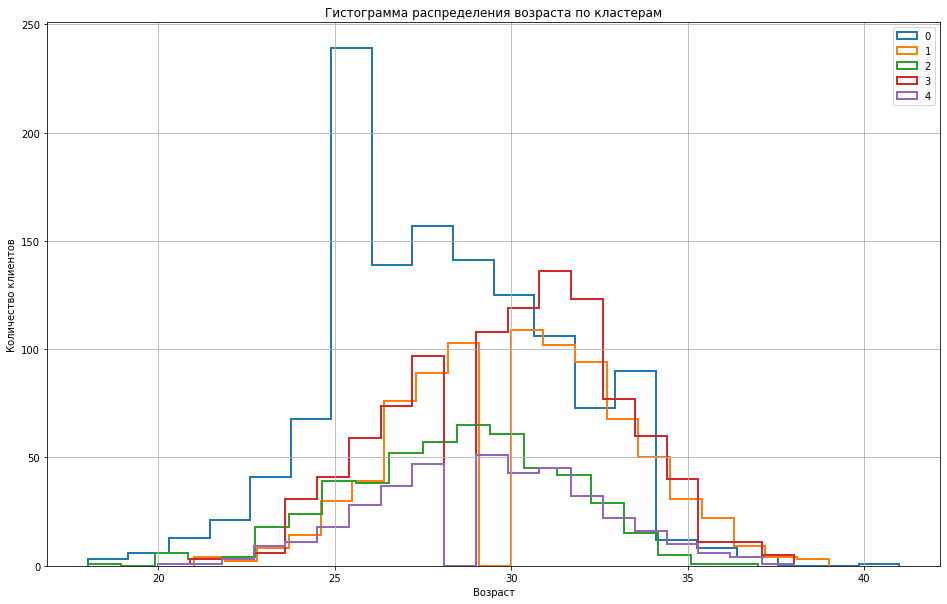

In [74]:
plt.figure(figsize=(16, 10))
cluster_gym['Age'].hist(bins=20, histtype = 'step', linewidth = 2)
plt.title('Гистограмма распределения возраста по кластерам')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.legend(cluster_labels)
plt.show()

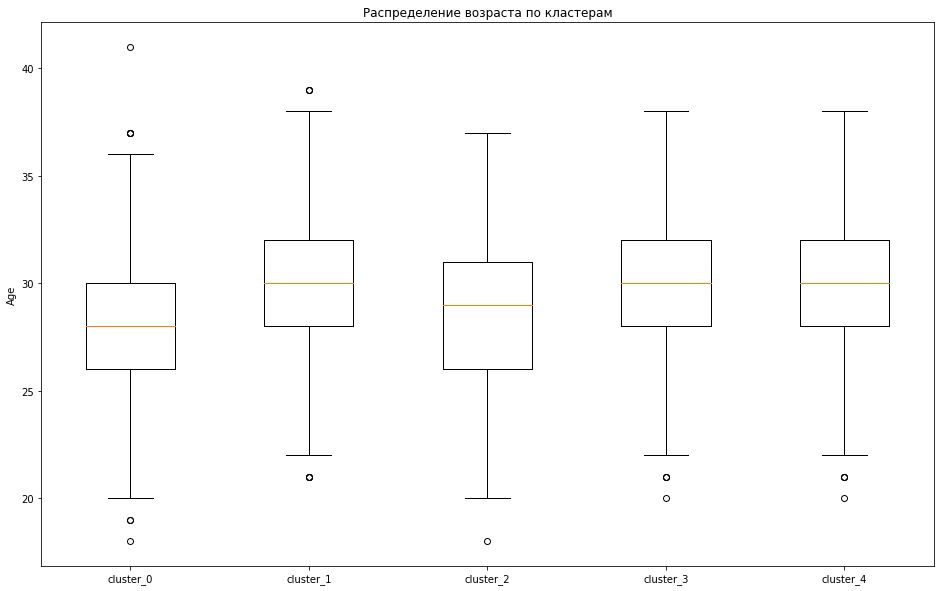

In [75]:
data_to_plot = [cluster_0['Age'],
                cluster_1['Age'],
               cluster_2['Age'],
               cluster_3['Age'],
               cluster_3['Age']]

fig = plt.figure(figsize=(16, 10))

plt.boxplot(data_to_plot, labels = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])
plt.ylabel('Age')
plt.title('Распределение возраста по кластерам')
plt.show()

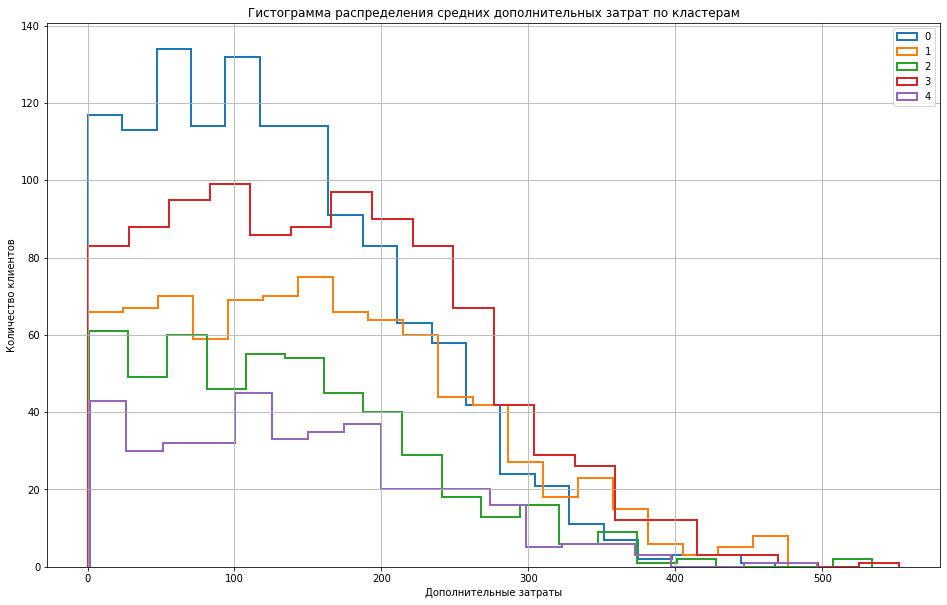

In [76]:
plt.figure(figsize=(16, 10))
cluster_gym['Avg_additional_charges_total'].hist(bins=20, histtype = 'step', linewidth = 2)
plt.title('Гистограмма распределения средних дополнительных затрат по кластерам')
plt.xlabel('Дополнительные затраты')
plt.ylabel('Количество клиентов')
plt.legend(cluster_labels)
plt.show()

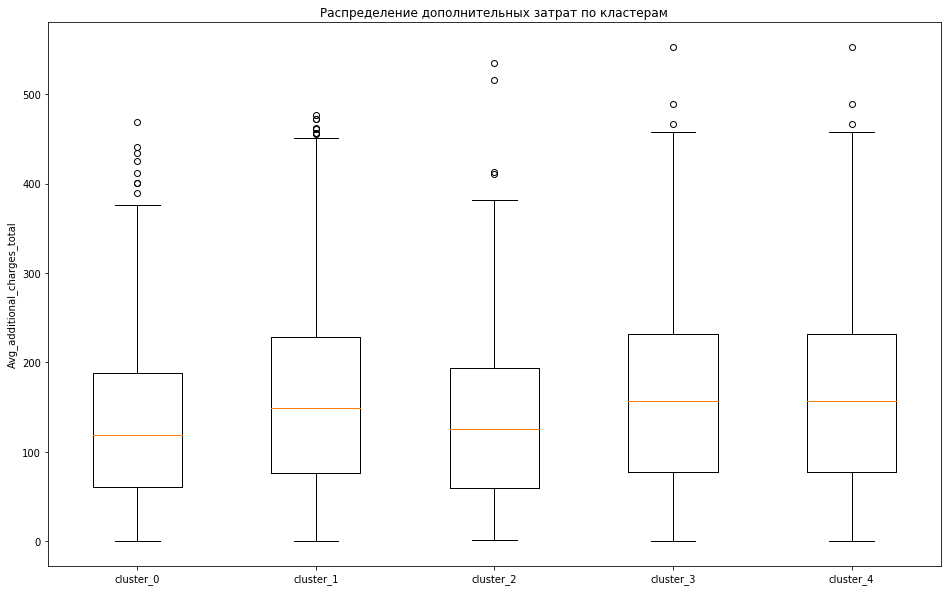

In [77]:
data_to_plot = [cluster_0['Avg_additional_charges_total'],
                cluster_1['Avg_additional_charges_total'],
               cluster_2['Avg_additional_charges_total'],
               cluster_3['Avg_additional_charges_total'],
               cluster_3['Avg_additional_charges_total']]

fig = plt.figure(figsize=(16, 10))

plt.boxplot(data_to_plot, labels = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])
plt.ylabel('Avg_additional_charges_total')
plt.title('Распределение дополнительных затрат по кластерам')
plt.show()

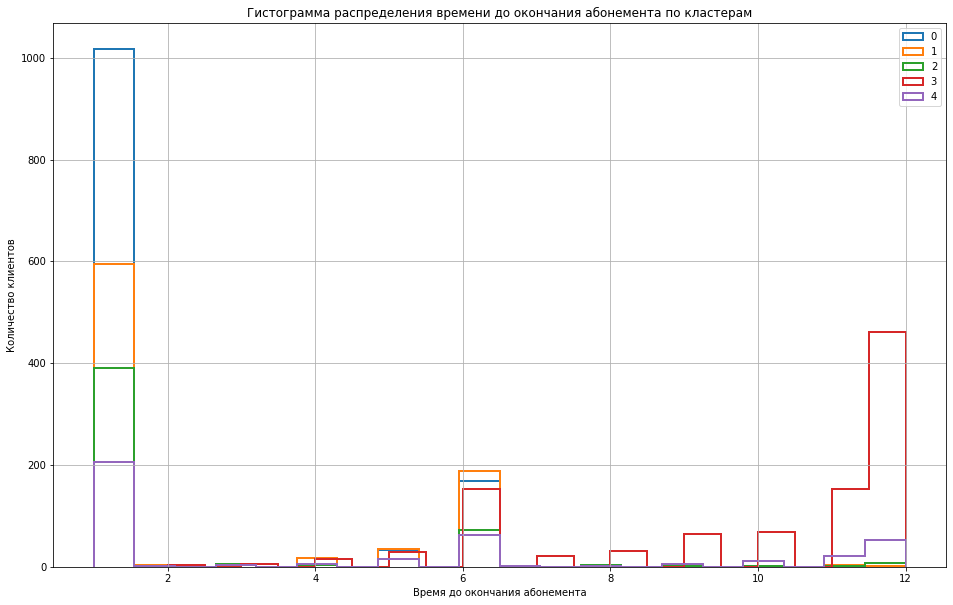

In [78]:
plt.figure(figsize=(16, 10))
cluster_gym['Month_to_end_contract'].hist(bins=20, histtype = 'step', linewidth = 2)
plt.title('Гистограмма распределения времени до окончания абонемента по кластерам')
plt.xlabel('Время до окончания абонемента')
plt.ylabel('Количество клиентов')
plt.legend(cluster_labels)
plt.show()

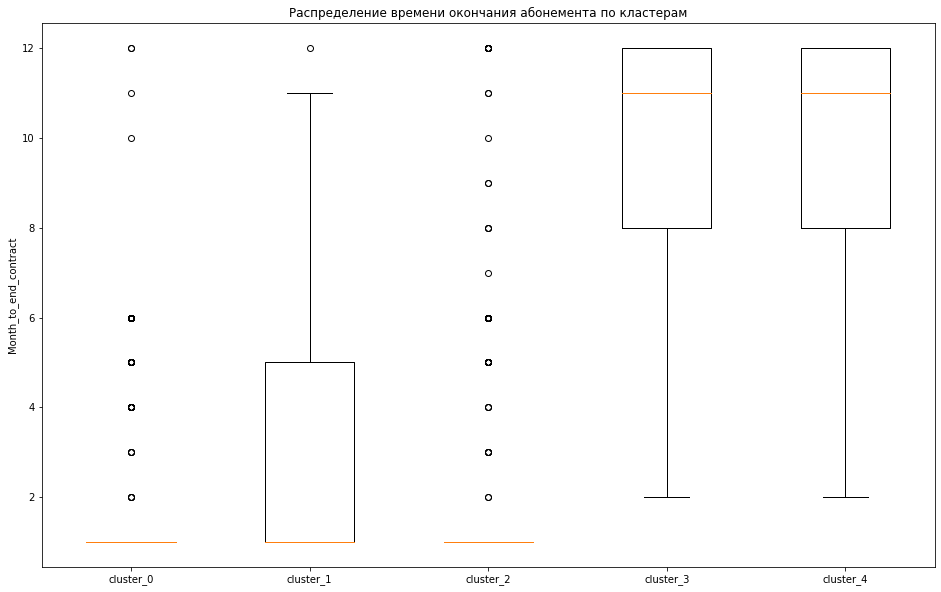

In [79]:
data_to_plot = [cluster_0['Month_to_end_contract'],
                cluster_1['Month_to_end_contract'],
               cluster_2['Month_to_end_contract'],
               cluster_3['Month_to_end_contract'],
               cluster_3['Month_to_end_contract']]

fig = plt.figure(figsize=(16, 10))

plt.boxplot(data_to_plot, labels = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])
plt.ylabel('Month_to_end_contract')
plt.title('Распределение времени окончания абонемента по кластерам')
plt.show()

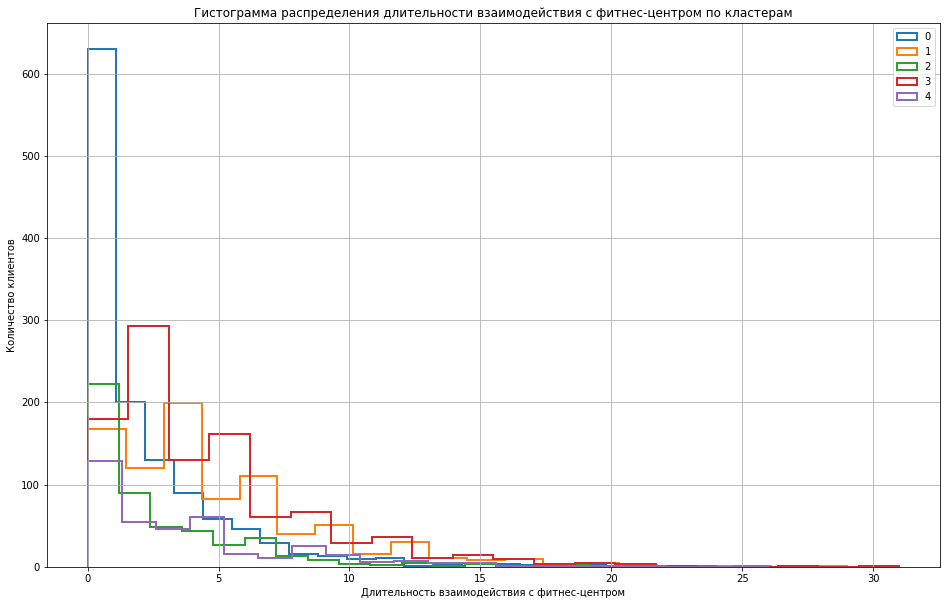

In [80]:
plt.figure(figsize=(16, 10))
cluster_gym['Lifetime'].hist(bins=20, histtype = 'step', linewidth = 2)
plt.title('Гистограмма распределения длительности взаимодействия с фитнес-центром по кластерам')
plt.xlabel('Длительность взаимодействия с фитнес-центром')
plt.ylabel('Количество клиентов')
plt.legend(cluster_labels)
plt.show()

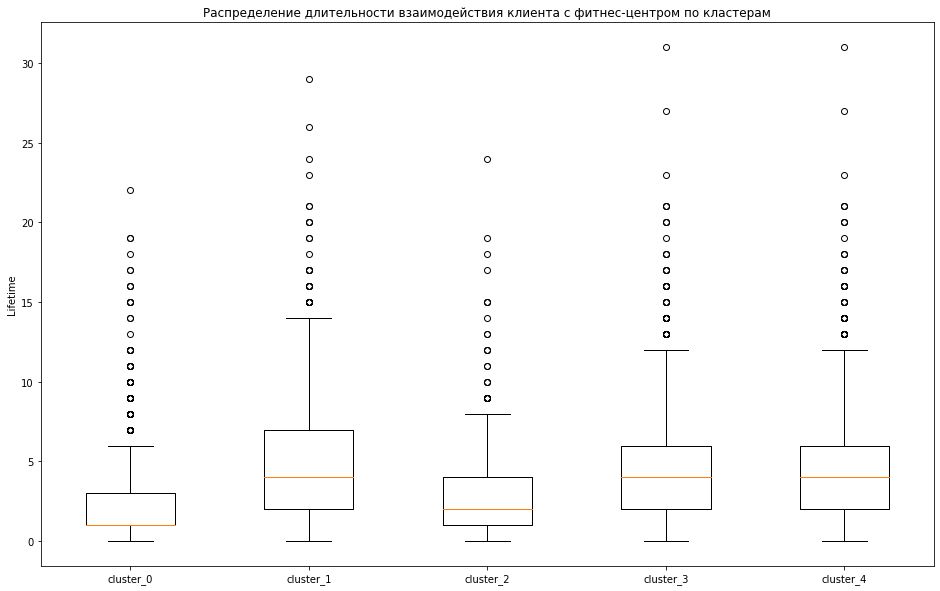

In [81]:
data_to_plot = [cluster_0['Lifetime'],
                cluster_1['Lifetime'],
               cluster_2['Lifetime'],
               cluster_3['Lifetime'],
               cluster_3['Lifetime']]

fig = plt.figure(figsize=(16, 10))

plt.boxplot(data_to_plot, labels = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])
plt.ylabel('Lifetime')
plt.title('Распределение длительности взаимодействия клиента с фитнес-центром по кластерам')
plt.show()

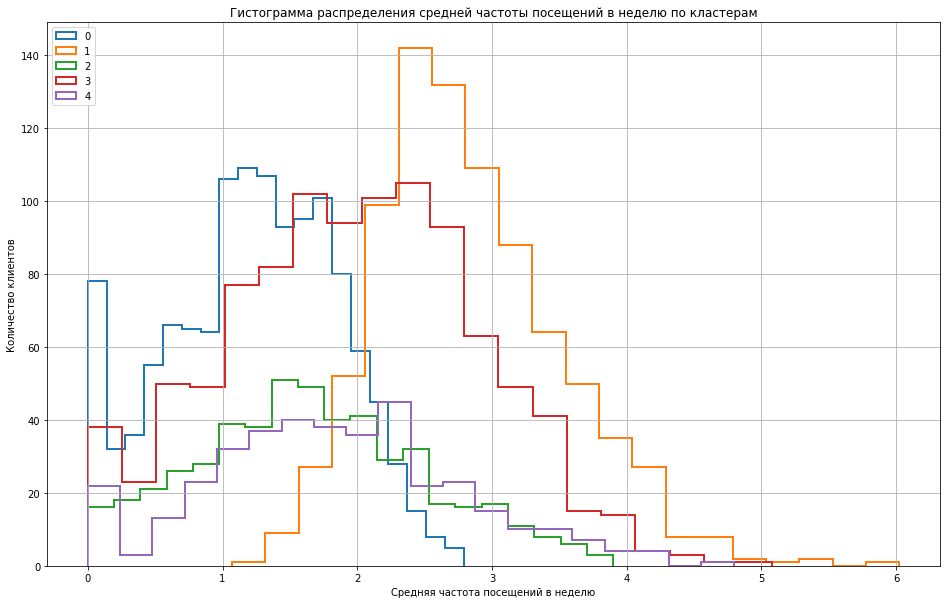

In [82]:
plt.figure(figsize=(16, 10))
cluster_gym['Avg_class_frequency_total'].hist(bins=20, histtype = 'step', linewidth = 2)
plt.title('Гистограмма распределения средней частоты посещений в неделю по кластерам')
plt.xlabel('Средняя частота посещений в неделю')
plt.ylabel('Количество клиентов')
plt.legend(cluster_labels)
plt.show()

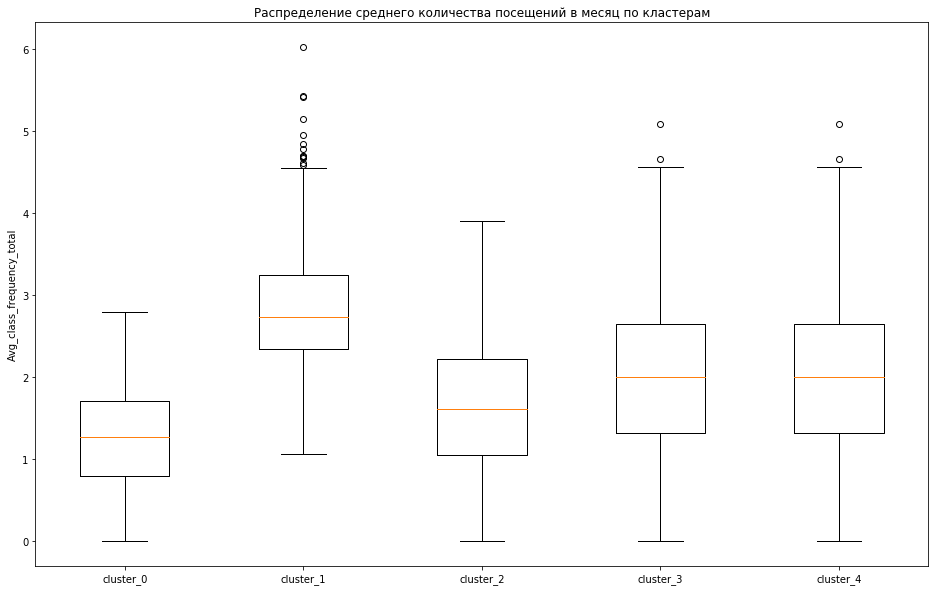

In [83]:
data_to_plot = [cluster_0['Avg_class_frequency_total'],
                cluster_1['Avg_class_frequency_total'],
               cluster_2['Avg_class_frequency_total'],
               cluster_3['Avg_class_frequency_total'],
               cluster_3['Avg_class_frequency_total']]

fig = plt.figure(figsize=(16, 10))

plt.boxplot(data_to_plot, labels = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])
plt.ylabel('Avg_class_frequency_total')
plt.title('Распределение среднего количества посещений в месяц по кластерам')
plt.show()

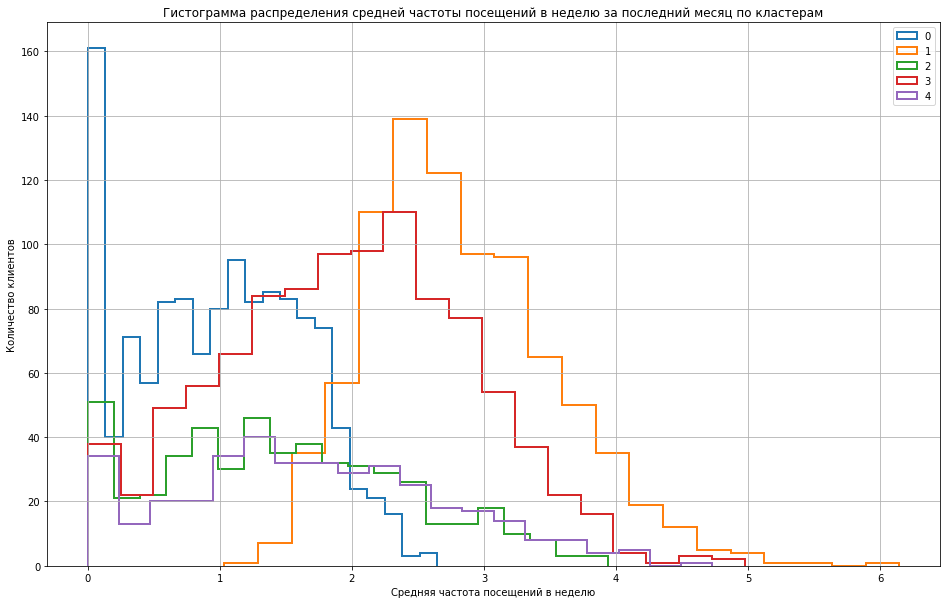

In [84]:
plt.figure(figsize=(16, 10))
cluster_gym['Avg_class_frequency_current_month'].hist(bins=20, histtype = 'step', linewidth = 2)
plt.title('Гистограмма распределения средней частоты посещений в неделю за последний месяц по кластерам')
plt.xlabel('Средняя частота посещений в неделю')
plt.ylabel('Количество клиентов')
plt.legend(cluster_labels)
plt.show()

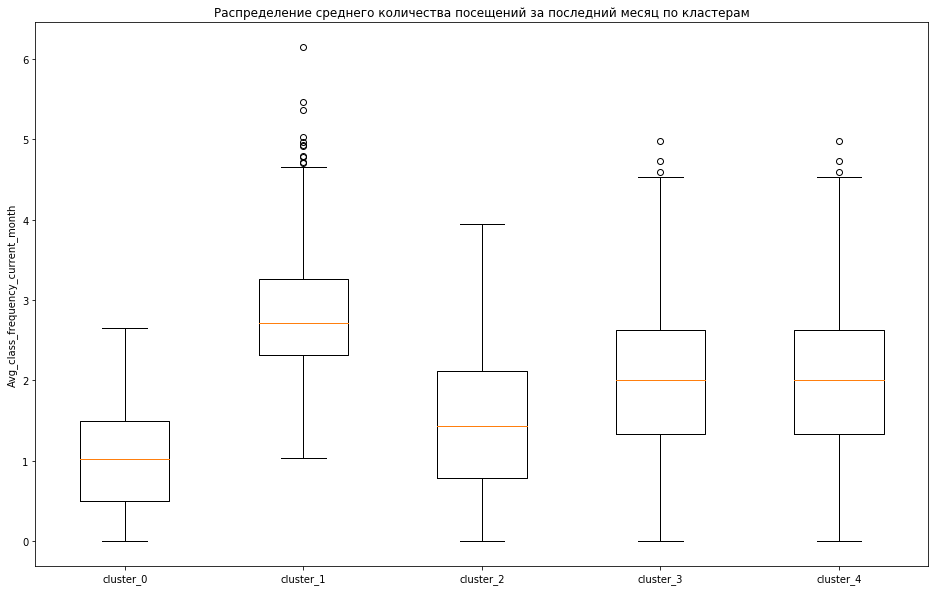

In [85]:
data_to_plot = [cluster_0['Avg_class_frequency_current_month'],
                cluster_1['Avg_class_frequency_current_month'],
               cluster_2['Avg_class_frequency_current_month'],
               cluster_3['Avg_class_frequency_current_month'],
               cluster_3['Avg_class_frequency_current_month']]

fig = plt.figure(figsize=(16, 10))

plt.boxplot(data_to_plot, labels = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])
plt.ylabel('Avg_class_frequency_current_month')
plt.title('Распределение среднего количества посещений за последний месяц по кластерам')
plt.show()

Изучение гистограмм распределения и боксплотов признаков подтверждают сделанные ранее выводы по характеристикам основных групп пользователей фитнес-центра и выделить кластеры с более лояльными клиентами.

In [86]:
# Посчитаем процент оттока и количество клиентов в кластерах
cluster_total = cluster_gym.agg({'Churn':'mean', 'Age':'count'}).reset_index()
cluster_total.columns = ['cluster_km', 'churn_rate', 'count']
cluster_total

,cluster_km,churn_rate,count
0,0,0.518845,1247
1,1,0.068845,857
2,2,0.442688,506
3,3,0.027861,1005
4,4,0.267532,385


### Выводы по кластеризации

По признакам кластеров можно сформулировать несколько групп клиентов:
 - "старички" - те кто давно ходит в зал, длительный абонемент, ходят 2 раза в неделю, тратят много на дополнительные услуги
 - "молодежь" - недавно пришли, короткий абонемент, ходят в среднем 1 раз в неделю, мало тратят на дополнительные услуги
 - "середнячки" - все показатели средние
 - "качки" - длительность абонемента средняя, много тратит на дополнительные услуги, давно ходят в зал, ходят на занятия 3 раза в неделю
 - "супер-старички" - те кто усердно занимаются, ходят 3 раза в неделю, но у них короткий абонемент, много тратят, давно ходят в зал

## 5. Общие выводы и базовые рекомендации по работе с клиентами

На основании анализа можно нарисовать портрет "идеального" клиента:
- Возраст около 30-ти лет
- Покупает абонемент длительностью 12 месяцев
- Тратит достаточно средств на дополнительные услуги
- Ходит в фитнес-центр от нескольких месяцев до полугода (не успело надоесть)
- Ходит в фитнес-центр 2-4 раза в неделю

В то же время были выявлены характеристики клиентов которые повлияли на уменьшение оттока:
- живут или работают рядом
- работают в компании-партнере
- пришли по акции "приведи друга"
- занимается в групповых занятиях

В то же время, выявлено 5 типичных групп клиентов:
 - "старички" - те кто давно ходит в зал, длительный абонемент, ходят 2 раза в неделю, тратят много на дополнительные услуги
 - "молодежь" - недавно пришли, короткий абонемент, ходят в среднем 1 раз в неделю, мало тратят на дополнительные услуги
 - "середнячки" - все показатели средние
 - "качки" - длительность абонемента средняя, много тратит на дополнительные услуги, давно ходят в зал, ходят на занятия 3 раза в неделю
 - "супер-старички" - те кто усердно занимаются, ходят 3 раза в неделю, но у них короткий абонемент, много тратят, давно ходят в зал

Исходя из этого рекомендации фитнес-центру:
- наращивать партнерскую сеть
- продолжать акцию "приведи друга"
- делать выгодные предложения на длительные абонементы
- разнообразить и увеличивать количество групповых занятий
- провести рекламную компанию в ближайшем районе (жилых домах и бизнес-центрах)
- разнообразить и увеличивать дополнительные услуги
- делать занятия в зале привлекательными для молодежи (групповые занятия)
- сделать автопродление карты
